In [7]:
import modsim

import numpy

%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Exercise 1

Write a function called `make_state` that creates a `State` object with the state variables `olin=10` and `wellesley=2`, and then returns the new `State` object.

Write a line of code that calls `make_state` and assigns the result to a variable named `init`.

In [2]:
def make_state():
    return modsim.State(olin=10, wellesley=2)

In [6]:
init = make_state()
init

,values
olin,10
wellesley,2


### Exercise 2
Read the documentation of Click to hide at https://numpy.org/doc/stable/reference/generated/numpy.linspace.html. Then use it to make an array of 101 equally spaced points between 0 and 1 (including both).

In [11]:
arr = numpy.linspace(0, 1, 101)
print(arr.min(), arr.max(), len(arr))

0.0 1.0 101


### Exercise 3

Wrap the code from this chapter in a function named `sweep_p1` that takes an array called `p1_array` as a parameter. It should create a new `SweepSeries` and run a simulation for each value of `p1` in `p1_array`, with `p2=0.2` and `num_steps=60`. It should store the results in the `SweepSeries` and return it.

Use your function to generate a `SweepSeries` and then plot the number of unhappy customers at Olin as a function of `p1`. Label the axes.

In [14]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    # We decrease one state variable and increase the
    # other so the total number of bikes is unchanged.

    #print('Moving a bike to Wellesley')
    if state.olin == 0:
        #print("No more bikes at Olin")
        state.olin_empty += 1
        return
    state.olin -= 1
    state.wellesley += 1


def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    # We decrease one state variable and increase the
    # other so the total number of bikes is unchanged.

    #print('Moving a bike to Olin')
    if state.wellesley == 0:
        #print("No more bikes at Wellesley")
        state.wellesley_empty += 1
        return
    state.wellesley -= 1
    state.olin += 1


def step(state, p1=0.5, p2=0.5):
    if modsim.flip(p1):
        bike_to_wellesley(state)
    
    if modsim.flip(p2):
        bike_to_olin(state)

In [19]:
def run_simulation(p1, p2, num_steps):
    state = modsim.State(olin=10, wellesley=2, olin_empty=0, wellesley_empty=0)
    
    for _ in range(num_steps):
        step(state, p1, p2)
        
    return state

In [17]:
def sweep_p1(p1_array):
    sweep = modsim.SweepSeries()

    for p1 in p1_array:
        final_state = run_simulation(p1=p1, p2=0.2, num_steps=60)
        sweep[p1] = final_state.olin_empty
    
    return sweep

In [20]:
results = sweep_p1(arr)

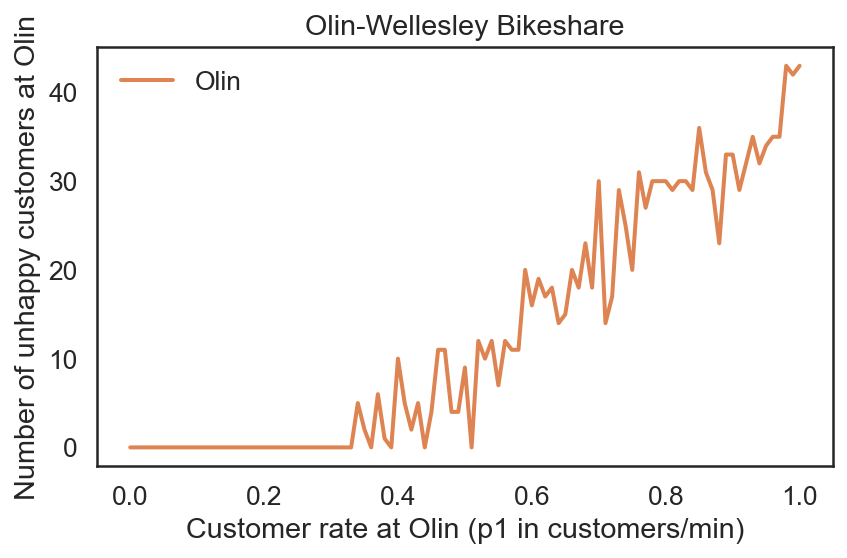

In [21]:
results.plot(label='Olin', color='C1')

modsim.decorate(
    title='Olin-Wellesley Bikeshare',
    xlabel='Customer rate at Olin (p1 in customers/min)', 
    ylabel='Number of unhappy customers at Olin')

### Exercise 4
Write a function called `sweep_p2` that runs simulations with `p1=0.5` and a range of values for `p2`. It should store the results in a `SweepSeries` and return the `SweepSeries`.

In [22]:
def sweep_p2(p2_array):
    sweep = modsim.SweepSeries()

    for p2 in p2_array:
        final_state = run_simulation(p1=0.5, p2=p2, num_steps=60)
        sweep[p2] = final_state.olin_empty
    
    return sweep

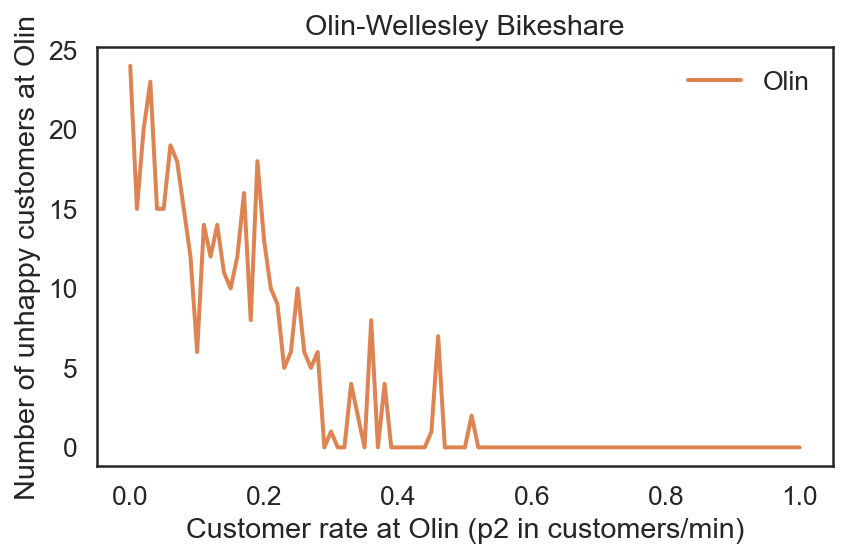

In [24]:
results = sweep_p2(arr)

results.plot(label='Olin', color='C1')

modsim.decorate(
    title='Olin-Wellesley Bikeshare',
    xlabel='Customer rate at Olin (p2 in customers/min)', 
    ylabel='Number of unhappy customers at Olin')

### Exercise 5

Because our simulations are random, the results vary from one run to another, and the results of a parameter sweep tend to be noisy. We can get a clearer picture of the relationship between a parameter and a metric by running multiple simulations with the same parameter and taking the average of the results.

Write a function called `run_multiple_simulations` that takes as parameters `p1`, `p2`, `num_steps`, and `num_runs`. `num_runs` specifies how many times it should call `run_simulation`.

After each run, it should store the total number of unhappy customers (at Olin or Wellesley) in a `TimeSeries`. At the end, it should return the `TimeSeries`.

Test your function with parameters
```
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
```

In [30]:
def run_multiple_simulations(p1, p2, num_steps, num_runs):
    
    results_olin = modsim.TimeSeries()
    results_wellesley = modsim.TimeSeries()
    
    for i in range(num_runs):
        final_state = run_simulation(p1=p1, p2=p2, num_steps=num_steps)
        results_olin[i] = final_state.olin_empty
        results_wellesley[i] = final_state.wellesley_empty
    
    return results_olin, results_wellesley

In [31]:
results_olin, results_wellesley = run_multiple_simulations(
    p1=0.3, p2=0.3, num_steps=60, num_runs=10,
)

In [35]:
print(f"Olin avg: {numpy.mean(results_olin)}\n")
print(f"Wellesley avg: {numpy.mean(results_wellesley)}\n")
print(f"Total avg: {numpy.mean(results_wellesley + results_olin)}")

Olin avg: 0.7

Wellesley avg: 1.4

Total avg: 2.1


### Exercise 6
Continuing the previous exercise, use `run_multiple_simulations` to run simulations with a range of values for `p1` and

```
p2 = 0.3
num_steps = 60
num_runs = 20
````

Store the results in a `SweepSeries`, then plot the average number of unhappy customers as a function of `p1`. Label the axes.

What value of `p1` minimizes the average number of unhappy customers?

In [39]:
def sweep_p1_multiple_runs(p1_array, p2=0.3, num_steps=60, num_runs=20):
    sweep_olin = modsim.SweepSeries()
    sweep_wellesley = modsim.SweepSeries()

    for p1 in p1_array:
        final_state_olin, final_state_wellesley = run_multiple_simulations(
            p1=p1, p2=0.2, num_steps=num_steps, num_runs=num_runs,
        )
        sweep_olin[p1] = numpy.mean(final_state_olin)
        sweep_wellesley[p1] = numpy.mean(final_state_wellesley)
    
    return sweep_olin, sweep_wellesley

In [40]:
sweep_olin, sweep_wellesley = sweep_p1_multiple_runs(arr)

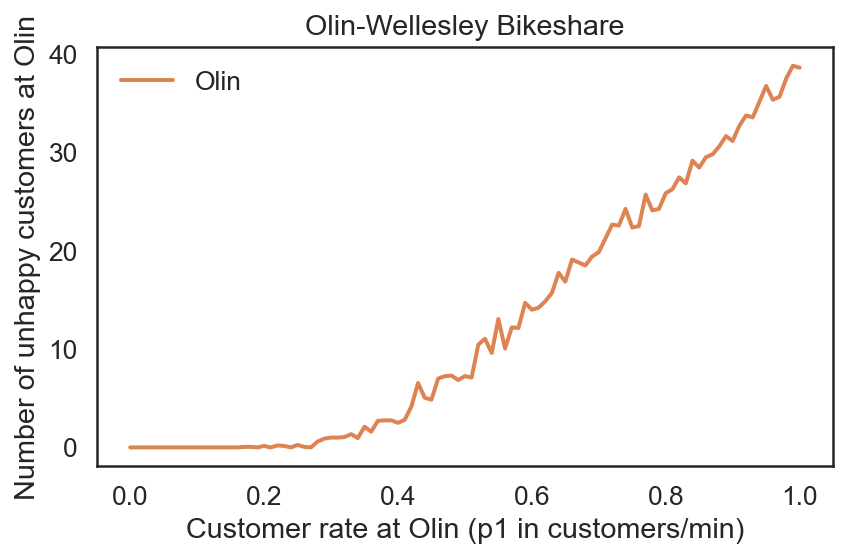

In [42]:
sweep_olin.plot(label='Olin', color='C1')

modsim.decorate(
    title='Olin-Wellesley Bikeshare',
    xlabel='Customer rate at Olin (p1 in customers/min)', 
    ylabel='Number of unhappy customers at Olin')

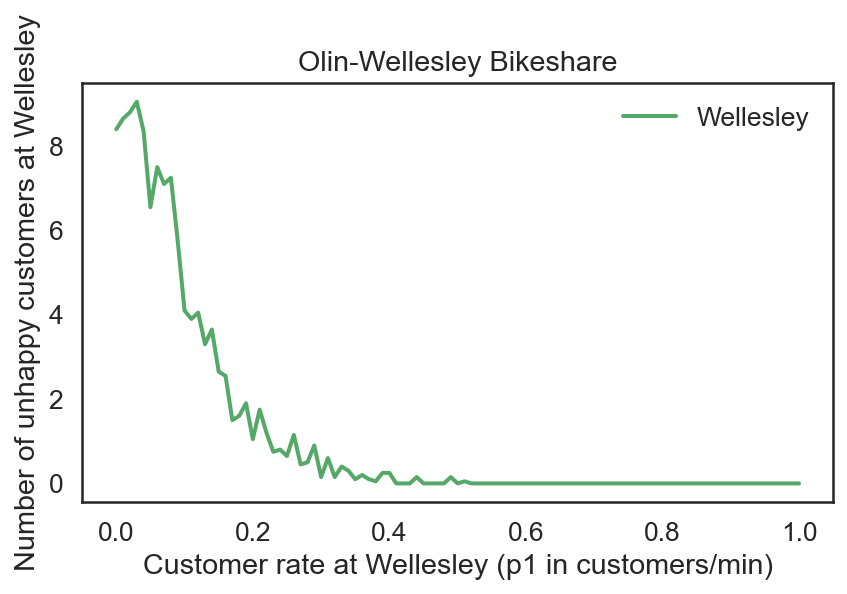

In [43]:
sweep_wellesley.plot(label='Wellesley', color='C2')

modsim.decorate(
    title='Olin-Wellesley Bikeshare',
    xlabel='Customer rate at Wellesley (p1 in customers/min)', 
    ylabel='Number of unhappy customers at Wellesley')